In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from keras.layers import Flatten, Conv1D, MaxPooling1D, Activation, concatenate, BatchNormalization, Add
from keras.optimizers import Adam
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Input, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping

seed=42

In [ ]:
df=pd.read_csv('features_flight_heli.csv')
df.dropna(inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6865 entries, 0 to 6864
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fname        6865 non-null   object 
 1   alt_max      6865 non-null   float64
 2   vert_acc     6865 non-null   float64
 3   horiz_speed  6865 non-null   float64
 4   dist         6865 non-null   float64
 5   is_maneuver  6865 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 321.9+ KB


In [ ]:
df.drop(['fname'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6865 entries, 0 to 6864
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   alt_max      6865 non-null   float64
 1   vert_acc     6865 non-null   float64
 2   horiz_speed  6865 non-null   float64
 3   dist         6865 non-null   float64
 4   is_maneuver  6865 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 268.3 KB


In [ ]:
df['is_maneuver'].value_counts()

1    5104
0    1761
Name: is_maneuver, dtype: int64

In [ ]:
Y = df['is_maneuver']
X = df.drop(['is_maneuver'], axis=1)

print(X.shape)
print(Y.shape)

(6865, 4)
(6865,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=seed)

In [ ]:
df.head()

,alt_max,vert_acc,horiz_speed,dist,is_maneuver
0,9479.0,-0.143793,241.277903,12.318341,0
1,10104.0,0.537735,171.344710,17.558203,1
2,3650.0,-1.418815,123.471539,0.605749,1
3,9479.0,-0.000318,235.397455,13.761831,1
4,10066.0,-0.208709,135.173804,13.815511,1


In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 1409],
       [   1, 4083]])

In [ ]:
train_data = np.array(X_train)
test_data=np.array(X_test)

In [ ]:
time_steps = 1
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], time_steps, X_train.shape[1]))


inputs = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
layer_1_ = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.5))(inputs)
x = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.5))(layer_1_)
x = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.5))(x)
layer_2_ = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.5))(x)
x = Add()([layer_1_, layer_2_])
x = Bidirectional(LSTM(units=64, recurrent_dropout=0.5))(x)
x = Dropout(0.5)(x)  # Adding dropout
x = Dense(16, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

modified_model = Model(inputs=inputs, outputs=x)



In [ ]:


# Compile the model
modified_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
modified_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1, 4)]       0           []                               
                                                                                                  
 bidirectional_42 (Bidirectiona  (None, 1, 1024)     2117632     ['input_10[0][0]']               
 l)                                                                                               
                                                                                                  
 bidirectional_43 (Bidirectiona  (None, 1, 1024)     6295552     ['bidirectional_42[0][0]']       
 l)                                                                                               
                                                                                            

In [ ]:
es = EarlyStopping(monitor='val_accuracy',mode='max', patience=10,restore_best_weights=True)

# Now you can fit the model using the reshaped data
history = modified_model.fit(X_train_reshaped, y_train, callbacks=[es], epochs=10, batch_size=10, validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/10
440/440 [==============================] - 208s 408ms/step - loss: 0.5037 - accuracy: 0.7947 - val_loss: 0.5643 - val_accuracy: 0.7452
Epoch 2/10
440/440 [==============================] - 180s 409ms/step - loss: 0.5136 - accuracy: 0.7826 - val_loss: 0.5264 - val_accuracy: 0.7634
Epoch 3/10
440/440 [==============================] - 183s 416ms/step - loss: 0.5040 - accuracy: 0.7951 - val_loss: 0.5061 - val_accuracy: 0.7971
Epoch 4/10
440/440 [==============================] - 177s 402ms/step - loss: 0.5085 - accuracy: 0.7901 - val_loss: 0.5569 - val_accuracy: 0.7434
Epoch 5/10
440/440 [==============================] - 179s 406ms/step - loss: 0.4936 - accuracy: 0.8040 - val_loss: 0.5364 - val_accuracy: 0.7825
Epoch 6/10
440/440 [==============================] - 178s 404ms/step - loss: 0.5689 - accuracy: 0.7439 - val_loss: 0.5671 - val_accuracy: 0.7316
Epoch 7/10
440/440 [==============================] - 178s 404ms/step - loss: 0.5242 - accuracy: 0.7787 - val_loss: 0.4981 -

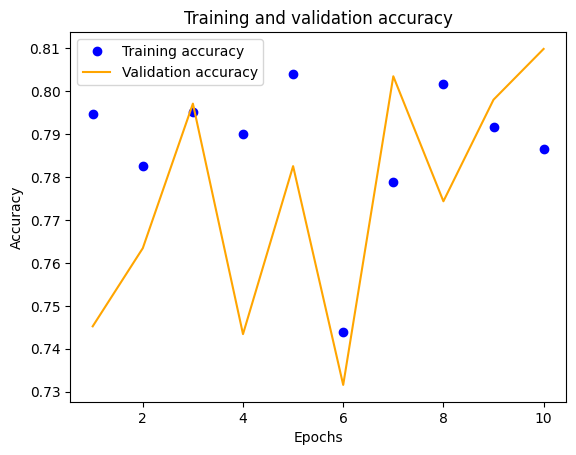

0.8098270893096924

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


np.max(val_acc)